## FEATURIZATION OF TEXT:-

We would consider the Glove model to get the 300 dimensional Word vectors.

We would follow two approaches to featurize text:-

1) Average Word2Vec

2) Tfidf_weighted Word2Vec

## MODELLING:-

We would fit the following 5 models on the given text data and would choose the best one:-

1) Naive Bayes

2) Logistic Regression

3) Linear SVM

4) GBDT

5) Random Forest

For each of the above models, we would do hyperparameter tuning.

### IMPORTING THE PREPROCESSED DATA

In [1]:
# Importing the libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier as gbc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack,coo_matrix
from tqdm import tqdm
import pickle

In [2]:
# Importing the preprocessed_data

preprocessed_data = pd.read_csv("preprocessed_data.csv")

preprocessed_data.head()

,textID,preprocessed_text,Length_of_Preprocessed_Text,class
0,2a0463352b,enough nothing hours,3,0
1,f358968122,clothes shopping tomorrow hate serious clothes...,9,1
2,449e7733f1,bored idea nice site,4,0
3,6099baf6e8,not think want come back guys read dms,8,1
4,f946da7a04,thomas drinking game tonight not work till tom...,8,0


### CHECKING FOR EMPTY ROWS AND REMOVING THEM

In [3]:
preprocessed_data.fillna('', inplace=True)

# Checking for no preprocessed text
def check_no_preprocessed_text(df):
    return [i for i in range(len(df)) if len(str(df.iloc[i,1]).split())==0]

# Calling the function check_no_preprocessed_text to check the index which has no text

list_of_indices = check_no_preprocessed_text(preprocessed_data)

list_of_indices

[5972, 9104]

In [4]:
# Dropping the rows which has no text

preprocessed_data = preprocessed_data.drop(labels = list_of_indices, axis = 0)

preprocessed_data.shape

(18406, 4)

### CHECKING AND REMOVING DUPLICATE PREPROCESSED TEXT

In [5]:
# Checking whether there are two same texts in the data

duplicate_text = preprocessed_data[preprocessed_data.duplicated(subset = ['preprocessed_text','class'])]

duplicate_text

,textID,preprocessed_text,Length_of_Preprocessed_Text,class


### SPLITTING OF DATA INTO TRAINING AND CV DATA

In [6]:
X = preprocessed_data[['preprocessed_text','Length_of_Preprocessed_Text']]
Y = preprocessed_data['class']

In [7]:
# Importing the library

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.25, stratify = Y, random_state = 42)

### TEXT FEATURIZATION

#### AVERAGE WORD2VEC

In [8]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [9]:
def average_w2v(preprocessed_text):
    avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(preprocessed_text): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)
    return avg_w2v_vectors

In [10]:
# Getting the vectors for the sentences
preprocessed_tr_avw2v = average_w2v(X_train.preprocessed_text.values)
preprocessed_te_avw2v = average_w2v(X_test.preprocessed_text.values)

print("Shape of the preprocessed text of training data after getting the sentence vectors ",np.array(preprocessed_tr_avw2v).shape)
print("Shape of the preprocessed text of test data after getting the sentence vectors ",np.array(preprocessed_te_avw2v).shape)

100%|███████████████████████████████████████████████████████████████████████████| 4602/4602 [00:00<00:00, 31327.24it/s]


Shape of the preprocessed text of training data after getting the sentence vectors  (13804, 300)
Shape of the preprocessed text of test data after getting the sentence vectors  (4602, 300)


#### TFIDF

In [11]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train.preprocessed_text.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [12]:
def tfidf_w2v(preprocessed_text):
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(preprocessed_text): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    return tfidf_w2v_vectors

In [13]:
# Getting the vectors for the sentences
preprocessed_tr_tfidfw2v = tfidf_w2v(X_train.preprocessed_text.values)
preprocessed_te_tfidfw2v = tfidf_w2v(X_test.preprocessed_text.values)

print("Shape of the preprocessed text of training data after getting the sentence vectors ",np.array(preprocessed_tr_tfidfw2v).shape)
print("Shape of the preprocessed text of test data after getting the sentence vectors ",np.array(preprocessed_te_tfidfw2v).shape)

100%|███████████████████████████████████████████████████████████████████████████| 4602/4602 [00:00<00:00, 15448.89it/s]

Shape of the preprocessed text of training data after getting the sentence vectors  (13804, 300)
Shape of the preprocessed text of test data after getting the sentence vectors  (4602, 300)


### SCALING OF THE NUMERICAL FEATURE

In [14]:
minmax = MinMaxScaler()

prep_length_tr = minmax.fit_transform(X_train.Length_of_Preprocessed_Text.values.reshape(-1,1))
prep_length_te = minmax.transform(X_test.Length_of_Preprocessed_Text.values.reshape(-1,1))

### FINAL FEATURE MATRIX

In [15]:
preprocessed_train_w2v = hstack((coo_matrix(preprocessed_tr_avw2v),prep_length_tr))
preprocessed_te_w2v = hstack((coo_matrix(preprocessed_te_avw2v),prep_length_te))
preprocessed_train_tfidfw2v = hstack((coo_matrix(preprocessed_tr_tfidfw2v),prep_length_tr))
preprocessed_te_tfidfw2v = hstack((coo_matrix(preprocessed_te_tfidfw2v),prep_length_te))

### FUNCTION TO DRAW THE CONFUSION MATRIX ALONG WITH PRECISION AND RECALL MATRIX

In [16]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 2,2 matrix, each cell (i,j) represents number of points of class i are predicted class j
    # The predictions are along the columns of the confusion matrix whereas the actual values are along the rows of confusion matrix.
    
    A =(((C.T)/(C.sum(axis=1))).T)
        
    B =(C/C.sum(axis=0))
        
    labels = [0,1]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    #print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(20,4))
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    #plt.show()

    #print("-"*50, "Precision matrix", "-"*50)
    #plt.figure(figsize=(10,5))
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    #plt.show()
    #print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    #print("-"*50, "Recall matrix"    , "-"*50)
    #plt.figure(figsize=(10,5))
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    #plt.show()
    #print("Sum of rows in Recall matrix",A.sum(axis=1))

#### FUNCTION TO CALCULATE BEST THRESHOLD AND PREDICT WITH THE SAME

In [17]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr(recall) is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

### LOGISTIC REGRESSION

#### HYPERPARAMETER TUNING

1) Alpha which is directly proportional to regularization.

2) Penalty which could L1, L2 or Elastic Net

#### AVERAGE WORD2VEC

The best set of parameters for the LR Classifier on the BOW featurized data are : {'penalty': 'L2', 'alpha': 0.001}


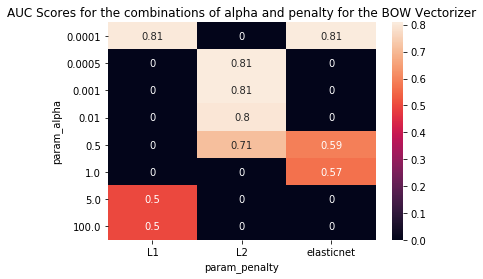

In [18]:
LR = SGDClassifier(loss = 'log')

params = {'alpha': [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100], 'penalty':['L1','L2','elasticnet']}

clf = RandomizedSearchCV(LR, param_distributions = params, scoring = 'roc_auc', cv=3, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_w2v, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = ["param_alpha","param_penalty"], inplace=True)


train_auc = results["mean_train_score"]
train_std = results["std_train_score"]
cv_auc = results["mean_test_score"]
cv_std = results["std_test_score"]
#hparam_alpha = pd.Series([np.log(x) for x in results.param_alpha.values])
#hparam_penalty = results.param_penalty.values

score_df = pd.pivot_table(data = results, index = "param_alpha", columns = "param_penalty", values = "mean_test_score")

# Removing the nan values from the dataset to avoid any errors during plotting of the auc scores for various combinations
score_df.fillna(0, inplace=True)

sns.heatmap(score_df, annot = True)
plt.title("AUC Scores for the combinations of alpha and penalty for the BOW Vectorizer")

print("The best set of parameters for the LR Classifier on the BOW featurized data are : {}".format(clf.best_params_))

#### TFIDF WEIGHTED WORD2VEC

The best set of parameters for the LR Classifier on the TFIDF featurized data are : {'penalty': 'L2', 'alpha': 0.0005}


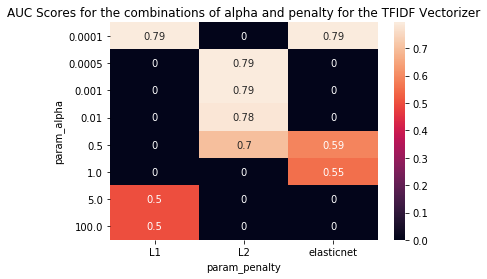

In [19]:
LR = SGDClassifier(loss = 'log')

params = {'alpha': [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100], 'penalty':['L1','L2','elasticnet']}

clf = RandomizedSearchCV(LR, param_distributions = params, scoring = 'roc_auc', cv=3, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_tfidfw2v, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = ["param_alpha","param_penalty"], inplace=True)


train_auc = results["mean_train_score"]
train_std = results["std_train_score"]
cv_auc = results["mean_test_score"]
cv_std = results["std_test_score"]
#hparam_alpha = pd.Series([np.log(x) for x in results.param_alpha.values])
#hparam_penalty = results.param_penalty.values

score_df = pd.pivot_table(data = results, index = "param_alpha", columns = "param_penalty", values = "mean_test_score")

# Removing the nan values from the dataset to avoid any errors during plotting of the auc scores for various combinations
score_df.fillna(0, inplace=True)

sns.heatmap(score_df, annot = True)
plt.title("AUC Scores for the combinations of alpha and penalty for the TFIDF Vectorizer")

print("The best set of parameters for the LR Classifier on the TFIDF featurized data are : {}".format(clf.best_params_))

#### BEST MODEL FITTING

#### AVERAGE W2V

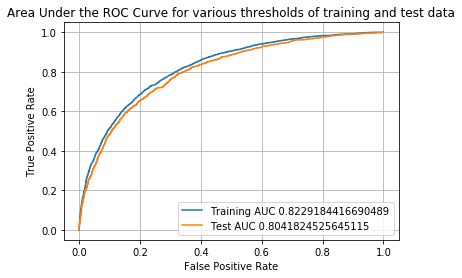

In [20]:
best_alpha = 0.001
best_penalty = 'L2'

# Fitting the multinomial naive bayes algorithm
best_mod = SGDClassifier(alpha = best_alpha, penalty = best_penalty, loss = 'log')

best_mod.fit(preprocessed_train_w2v, Y_train)

y_train_pred = best_mod.predict_proba(preprocessed_train_w2v)[:,1]
y_test_pred = best_mod.predict_proba(preprocessed_te_w2v)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

best_alpha_LR_bow = best_alpha
best_penalty_LR_bow = best_penalty

#### TEST DATA PREDICTION AND CONFUSION MATRIX

the maximum value of tpr*(1-fpr) 0.5564930582388122 for threshold 0.421
Number of misclassified points  26.727509778357234


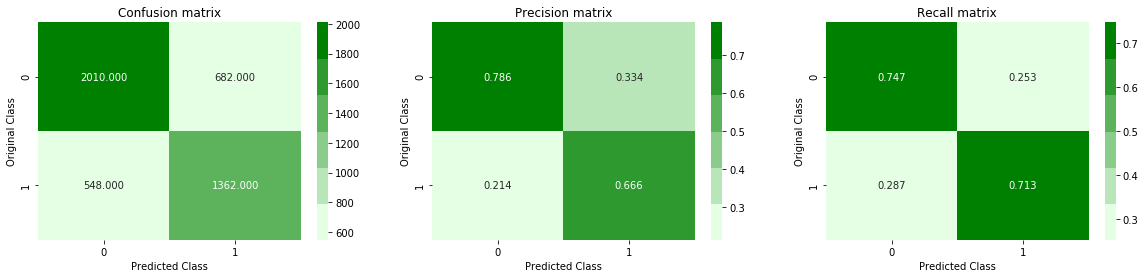

In [21]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred,best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_LR_bow = best_t

#### TFIDF WEIGHTED WORD2VEC

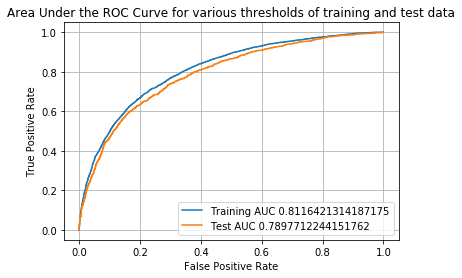

In [22]:
best_alpha = 0.0005
best_penalty = 'L2'

# Fitting the multinomial naive bayes algorithm
best_mod = SGDClassifier(alpha = best_alpha, penalty = best_penalty, loss = 'log')

best_mod.fit(preprocessed_train_tfidfw2v, Y_train)

y_train_pred = best_mod.predict_proba(preprocessed_train_tfidfw2v)[:,1]
y_test_pred = best_mod.predict_proba(preprocessed_te_tfidfw2v)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

best_alpha_LR_tfidf = best_alpha
best_penalty_LR_tfidf = best_penalty

#### TEST DATA PREDICTION AND CONFUSION MATRIX

the maximum value of tpr*(1-fpr) 0.5435459048986013 for threshold 0.358
Number of misclassified points  27.531508039982615


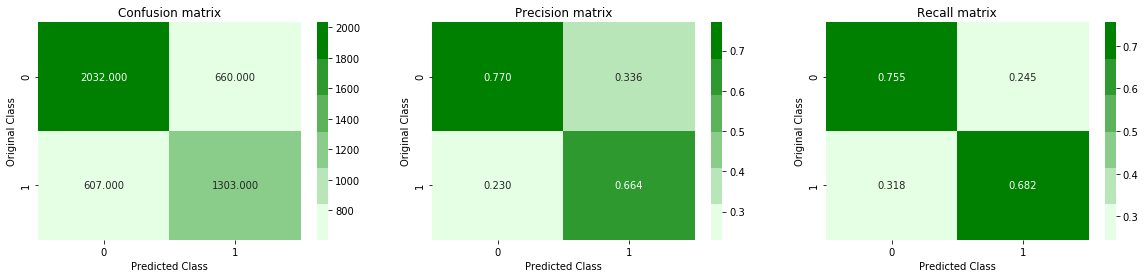

In [23]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred,best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_LR_tfidf = best_t

### LINEAR SVM

#### HYPERPARAMETER TUNING

1) C which is the inverse of the regularization strength and it penalizes the outliers.

#### AVERAGE W2V

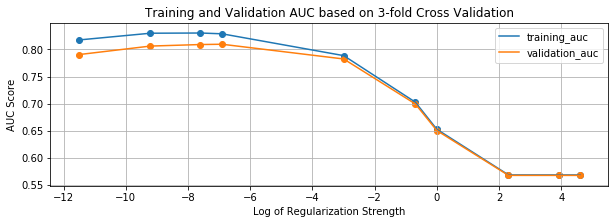

The best regularization strength parameter alpha on the random search over the given hyperparameter space for CountVectorizer using Linear SVM is :  {'alpha': 0.001}


In [24]:
SV = SGDClassifier(loss = 'hinge')

params = {'alpha': [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}

clf = RandomizedSearchCV(SV, param_distributions = params, scoring = 'roc_auc', cv=3, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_w2v, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = "param_alpha", inplace=True)

train_auc = results["mean_train_score"]
train_std = results["std_train_score"]
cv_auc = results["mean_test_score"]
cv_std = results["std_test_score"]
hparam = pd.Series([np.log(x) for x in results.param_alpha.values])

plt.figure(figsize = (10,3))
plt.plot(hparam, train_auc, label = "training_auc")
plt.plot(hparam, cv_auc, label = "validation_auc")
plt.scatter(hparam, train_auc)
plt.scatter(hparam, cv_auc)
plt.xlabel("Log of Regularization Strength")
plt.ylabel("AUC Score")
plt.title("Training and Validation AUC based on 3-fold Cross Validation")
plt.legend()
plt.grid()
plt.show()

print("The best regularization strength parameter alpha on the random search over the given hyperparameter space for CountVectorizer using Linear SVM is : ", clf.best_params_)

#### TFIDF WEIGHTED W2V

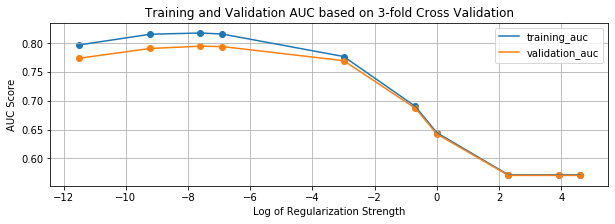

The best regularization strength parameter alpha on the random search over the given hyperparameter space for TFIDF Vectorizer using Linear SVM is :  {'alpha': 0.0005}


In [25]:
SV = SGDClassifier(loss = 'hinge')

params = {'alpha': [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}

clf = RandomizedSearchCV(SV, param_distributions = params, scoring = 'roc_auc', cv=3, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_tfidfw2v, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = "param_alpha", inplace=True)

train_auc = results["mean_train_score"]
train_std = results["std_train_score"]
cv_auc = results["mean_test_score"]
cv_std = results["std_test_score"]
hparam = pd.Series([np.log(x) for x in results.param_alpha.values])

plt.figure(figsize = (10,3))
plt.plot(hparam, train_auc, label = "training_auc")
plt.plot(hparam, cv_auc, label = "validation_auc")
plt.scatter(hparam, train_auc)
plt.scatter(hparam, cv_auc)
plt.xlabel("Log of Regularization Strength")
plt.ylabel("AUC Score")
plt.title("Training and Validation AUC based on 3-fold Cross Validation")
plt.legend()
plt.grid()
plt.show()

print("The best regularization strength parameter alpha on the random search over the given hyperparameter space for TFIDF Vectorizer using Linear SVM is : ", clf.best_params_)

#### BEST MODEL FITTING

#### AVERAGE W2V

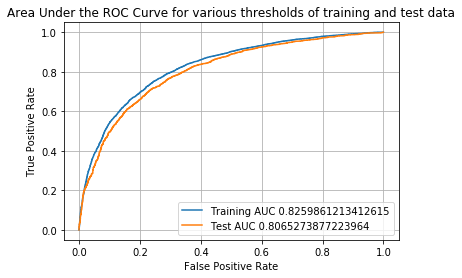

In [26]:
best_alpha = 0.001

# Fitting the multinomial naive bayes algorithm
best_mod = SGDClassifier(alpha = best_alpha, loss = 'hinge')
cal_clf = CalibratedClassifierCV(best_mod, method = "sigmoid", cv = 3)

cal_clf.fit(preprocessed_train_w2v, Y_train)

y_train_pred = cal_clf.predict_proba(preprocessed_train_w2v)[:,1]
y_test_pred = cal_clf.predict_proba(preprocessed_te_w2v)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

best_alpha_SVM_bow = best_alpha

#### TEST DATA PREDICTION AND CONFUSION MATRIX

the maximum value of tpr*(1-fpr) 0.5673539706463288 for threshold 0.393
Number of misclassified points  26.705780095610603


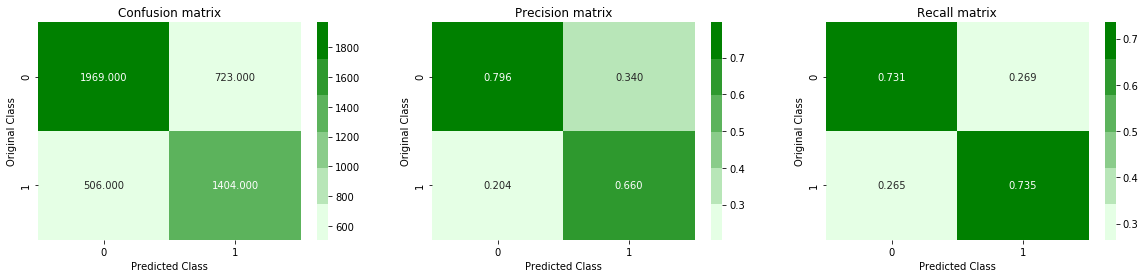

In [27]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred,best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_SVM_bow = best_t

#### TFIDF WEIGHTED W2V

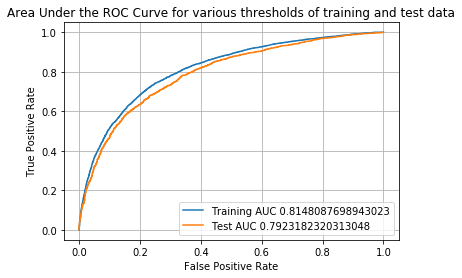

In [28]:
best_alpha = 0.0005

# Fitting the multinomial naive bayes algorithm
best_mod = SGDClassifier(alpha = best_alpha, loss = 'hinge')
cal_clf = CalibratedClassifierCV(best_mod, method = "sigmoid", cv = 3)

cal_clf.fit(preprocessed_train_tfidfw2v, Y_train)

y_train_pred = cal_clf.predict_proba(preprocessed_train_tfidfw2v)[:,1]
y_test_pred = cal_clf.predict_proba(preprocessed_te_tfidfw2v)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

best_alpha_SVM_tfidf = best_alpha

#### TEST DATA PREDICTION AND CONFUSION MATRIX

the maximum value of tpr*(1-fpr) 0.5567510471680932 for threshold 0.398
Number of misclassified points  28.096479791395048


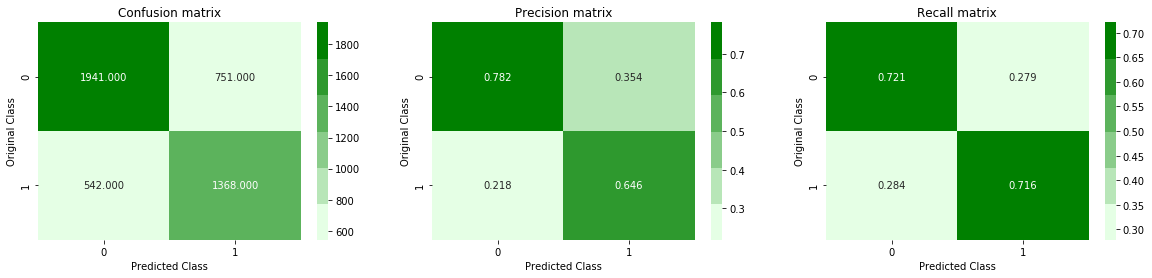

In [29]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred,best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_SVM_tfidf = best_t

### GRADIENT BOOSTED DECISION TREES

#### HYPERPARAMETER TUNING

1) No. of Base Learners

2) Learning Rate

#### AVERAGE W2V

The best set of parameters for the GBDT Classifier on the BOW featurized data are : {'n_estimators': 100, 'learning_rate': 0.2}


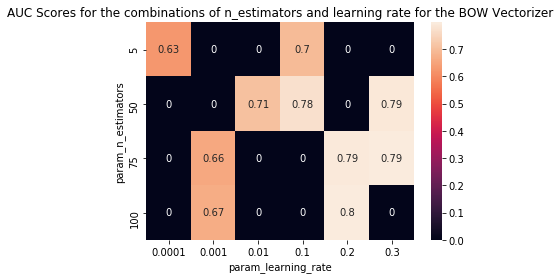

In [30]:
gbdt_clf = gbc()

params = {'n_estimators':[5,10,50,75,100], 'learning_rate':[0.0001,0.001,0.01,0.1,0.2,0.3]}

clf = RandomizedSearchCV(gbdt_clf, param_distributions = params, scoring = 'roc_auc', cv=3, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_w2v, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = ["param_n_estimators","param_learning_rate"], inplace=True)


train_auc = results["mean_train_score"]
train_std = results["std_train_score"]
cv_auc = results["mean_test_score"]
cv_std = results["std_test_score"]

score_df = pd.pivot_table(data = results, index = "param_n_estimators", columns = "param_learning_rate", values = "mean_test_score")

# Removing the nan values from the dataset to avoid any errors during plotting of the auc scores for various combinations
score_df.fillna(0, inplace=True)

sns.heatmap(score_df, annot = True)
plt.title("AUC Scores for the combinations of n_estimators and learning rate for the BOW Vectorizer")

print("The best set of parameters for the GBDT Classifier on the BOW featurized data are : {}".format(clf.best_params_))

#### TFIDF WEIGHTED W2V

The best set of parameters for the GBDT Classifier on the TFIDF featurized data are : {'n_estimators': 100, 'learning_rate': 0.2}


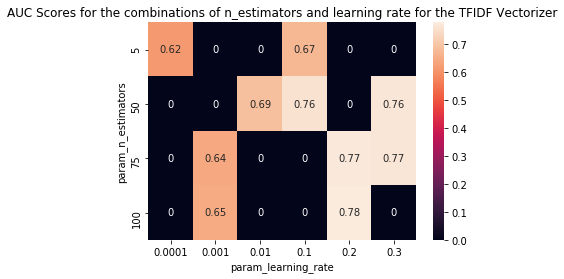

In [31]:
gbdt_clf = gbc()

params = {'n_estimators':[5,10,50,75,100], 'learning_rate':[0.0001,0.001,0.01,0.1,0.2,0.3]}

clf = RandomizedSearchCV(gbdt_clf, param_distributions = params, scoring = 'roc_auc', cv=3, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_tfidfw2v, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = ["param_n_estimators","param_learning_rate"], inplace=True)


train_auc = results["mean_train_score"]
train_std = results["std_train_score"]
cv_auc = results["mean_test_score"]
cv_std = results["std_test_score"]

score_df = pd.pivot_table(data = results, index = "param_n_estimators", columns = "param_learning_rate", values = "mean_test_score")

# Removing the nan values from the dataset to avoid any errors during plotting of the auc scores for various combinations
score_df.fillna(0, inplace=True)

sns.heatmap(score_df, annot = True)
plt.title("AUC Scores for the combinations of n_estimators and learning rate for the TFIDF Vectorizer")

print("The best set of parameters for the GBDT Classifier on the TFIDF featurized data are : {}".format(clf.best_params_))

#### BEST MODEL FITTING

#### AVERAGE W2V

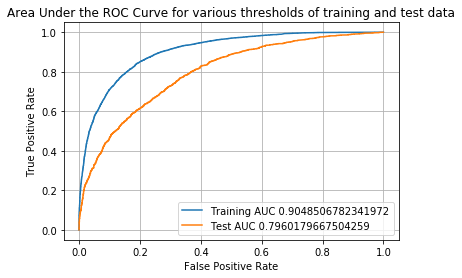

In [32]:
best_n_estimators = 100
best_learning_rate = 0.2

# Fitting the multinomial naive bayes algorithm
best_mod = gbc(n_estimators = best_n_estimators, learning_rate = best_learning_rate)

best_mod.fit(preprocessed_train_w2v, Y_train)

y_train_pred = best_mod.predict_proba(preprocessed_train_w2v)[:,1]
y_test_pred = best_mod.predict_proba(preprocessed_te_w2v)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

best_n_est_gbdt_bow = best_n_estimators
best_l_rate_gbdt_bow = best_learning_rate

#### TEST DATA PREDICTION AND CONFUSION MATRIX

the maximum value of tpr*(1-fpr) 0.6821899120600368 for threshold 0.405
Number of misclassified points  28.596262494567583


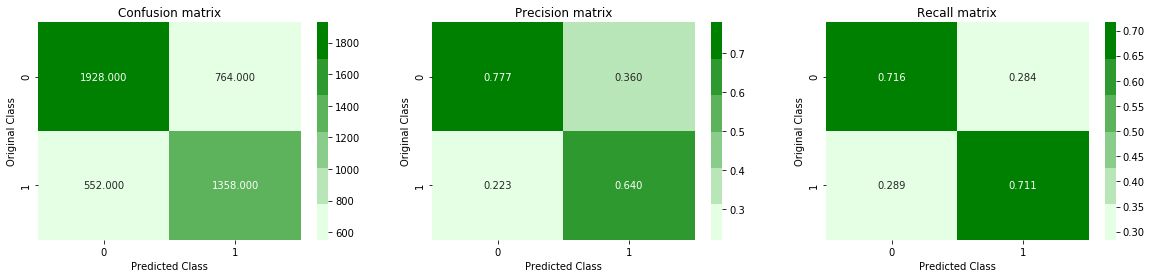

In [33]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred,best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_gbdt_bow = best_t

#### TFIDF WEIGHTED W2V

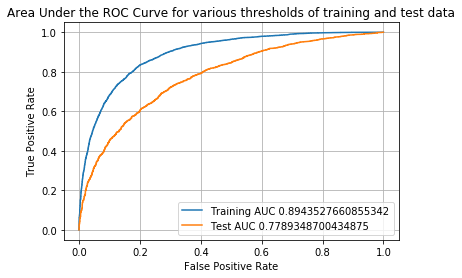

In [34]:
best_n_estimators = 100
best_learning_rate = 0.2

# Fitting the multinomial naive bayes algorithm
best_mod = gbc(n_estimators = best_n_estimators, learning_rate = best_learning_rate)

best_mod.fit(preprocessed_train_tfidfw2v, Y_train)

y_train_pred = best_mod.predict_proba(preprocessed_train_tfidfw2v)[:,1]
y_test_pred = best_mod.predict_proba(preprocessed_te_tfidfw2v)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

best_n_est_gbdt_tfidf = best_n_estimators
best_l_rate_gbdt_tfidf = best_learning_rate

#### TEST DATA PREDICTION AND CONFUSION MATRIX

the maximum value of tpr*(1-fpr) 0.6677119883791497 for threshold 0.405
Number of misclassified points  28.8135593220339


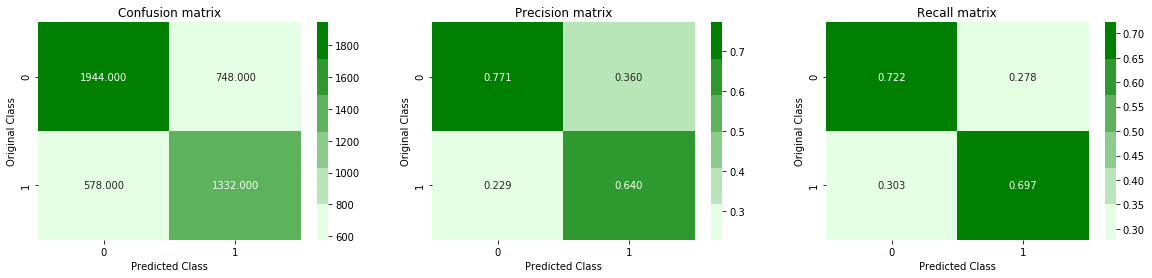

In [35]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred,best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_gbdt_tfidf = best_t

### RANDOM FORESTS

#### HYPERPARAMETER TUNING

1) <b>n_estimators</b> which is the number of base learners or the individual decision trees.

2) <b>max_depth</b> which is the maximum depth to which the decision trees should grow.

#### AVERAGE W2V

The best set of parameters for the Random Forest Classifier on the average word2vec featurized data are : {'n_estimators': 200, 'max_depth': 10}


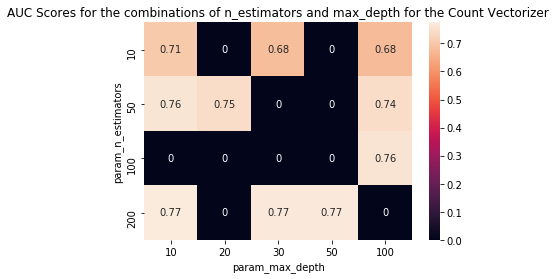

In [36]:
rf_clf = RandomForestClassifier()

params = {'n_estimators':[10,50,100,200], 'max_depth':[10,20,30,50,100]}

clf = RandomizedSearchCV(rf_clf, param_distributions = params, scoring = 'roc_auc', cv=3, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_w2v, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = ["param_n_estimators","param_max_depth"], inplace=True)


train_auc = results["mean_train_score"]
train_std = results["std_train_score"]
cv_auc = results["mean_test_score"]
cv_std = results["std_test_score"]

score_df = pd.pivot_table(data = results, index = "param_n_estimators", columns = "param_max_depth", values = "mean_test_score")

# Removing the nan values from the dataset to avoid any errors during plotting of the auc scores for various combinations
score_df.fillna(0, inplace=True)

sns.heatmap(score_df, annot = True)
plt.title("AUC Scores for the combinations of n_estimators and max_depth for the Count Vectorizer")

print("The best set of parameters for the Random Forest Classifier on the average word2vec featurized data are : {}".format(clf.best_params_))

#### TFIDF WEIGHTED W2V

The best set of parameters for the Random Forest Classifier on the TFIDF weighted word2vec featurized data are : {'n_estimators': 200, 'max_depth': 10}


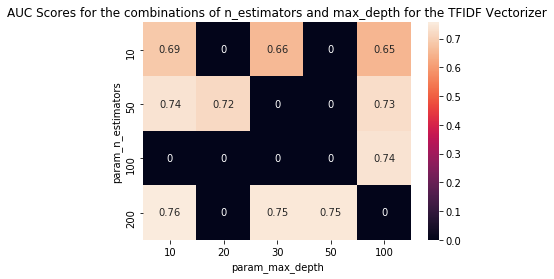

In [37]:
rf_clf = RandomForestClassifier()

params = {'n_estimators':[10,50,100,200], 'max_depth':[10,20,30,50,100]}

clf = RandomizedSearchCV(rf_clf, param_distributions = params, scoring = 'roc_auc', cv=3, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_tfidfw2v, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = ["param_n_estimators","param_max_depth"], inplace=True)


train_auc = results["mean_train_score"]
train_std = results["std_train_score"]
cv_auc = results["mean_test_score"]
cv_std = results["std_test_score"]

score_df = pd.pivot_table(data = results, index = "param_n_estimators", columns = "param_max_depth", values = "mean_test_score")

# Removing the nan values from the dataset to avoid any errors during plotting of the auc scores for various combinations
score_df.fillna(0, inplace=True)

sns.heatmap(score_df, annot = True)
plt.title("AUC Scores for the combinations of n_estimators and max_depth for the TFIDF Vectorizer")

print("The best set of parameters for the Random Forest Classifier on the TFIDF weighted word2vec featurized data are : {}".format(clf.best_params_))

#### BEST MODEL FITTING

#### AVERAGE W2V

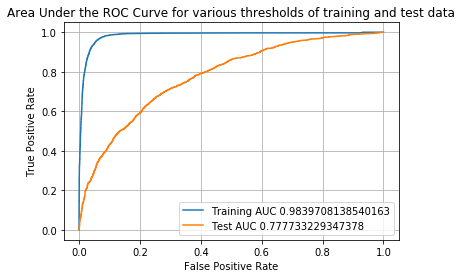

In [38]:
best_n_estimators = 200
best_max_depth = 10

# Fitting the multinomial naive bayes algorithm
best_mod_rf_bow = RandomForestClassifier(n_estimators = best_n_estimators, max_depth = best_max_depth, oob_score = True, random_state = 42)

best_mod_rf_bow.fit(preprocessed_train_w2v, Y_train)

y_train_pred = best_mod_rf_bow.predict_proba(preprocessed_train_w2v)[:,1]
y_test_pred = best_mod_rf_bow.predict_proba(preprocessed_te_w2v)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

best_n_est_rfclf_bow = best_n_estimators
best_max_depth_rfclf_bow = best_max_depth

#### TEST DATA PREDICTION AND CONFUSION MATRIX

the maximum value of tpr*(1-fpr) 0.9033949159860727 for threshold 0.44
Number of misclassified points  28.42242503259452


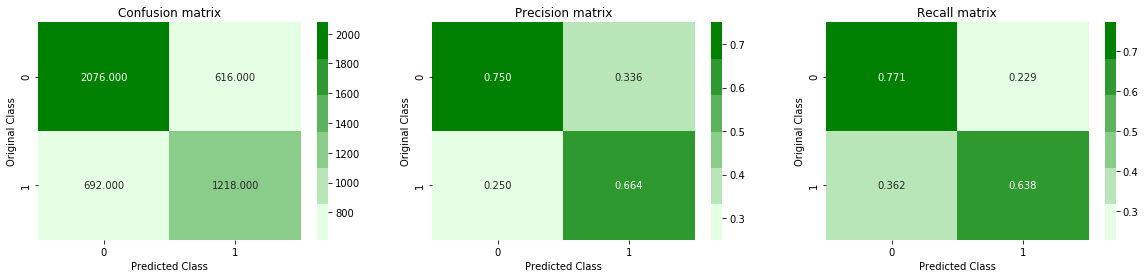

In [39]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred,best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_rfclf_bow = best_t

#### TFIDF WEIGHTED W2V

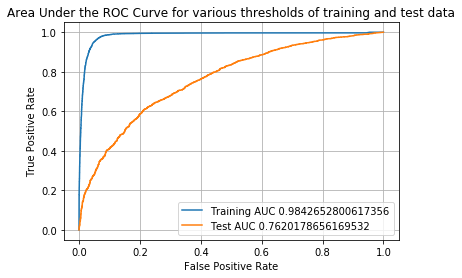

In [40]:
best_n_estimators = 200
best_max_depth = 10

# Fitting the multinomial naive bayes algorithm
best_mod_rf_tfidf = RandomForestClassifier(n_estimators = best_n_estimators, max_depth = best_max_depth, oob_score = True, random_state = 42)

best_mod_rf_tfidf.fit(preprocessed_train_tfidfw2v, Y_train)

y_train_pred = best_mod_rf_tfidf.predict_proba(preprocessed_train_tfidfw2v)[:,1]
y_test_pred = best_mod_rf_tfidf.predict_proba(preprocessed_te_tfidfw2v)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

best_n_est_rfclf_tfidf = best_n_estimators
best_max_depth_rfclf_tfidf = best_max_depth

#### TEST DATA PREDICTION AND CONFUSION MATRIX

the maximum value of tpr*(1-fpr) 0.9091089978908027 for threshold 0.441
Number of misclassified points  28.857018687527162


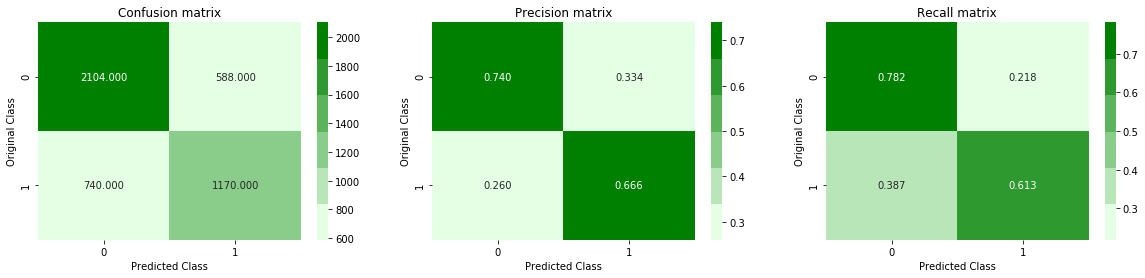

In [41]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred,best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_rfclf_tfidf = best_t

#### MODEL SUMMARY:-

We have used five models to fit on the unigrams BOW and tfidf vectorized data and here are the results summarized in one table as under:-

In [42]:
summary = {'Model':['Naive Bayes','Logistic Regression','Linear SVM','GBDT','Random Forest']*2,
           'Vectorizer':['Av_W2V']*5+['TFIDF_Weighted_W2V']*5, 'Recall_Positive_Class':["NA",0.713,0.735,0.711,0.638,"NA",0.682,0.716,0.697,0.613]}

fin_summary = pd.DataFrame(summary)

fin_summary

,Model,Vectorizer,Recall_Positive_Class
0,Naive Bayes,Av_W2V,NA
1,Logistic Regression,Av_W2V,0.713
2,Linear SVM,Av_W2V,0.735
3,GBDT,Av_W2V,0.711
4,Random Forest,Av_W2V,0.638
5,Naive Bayes,TFIDF_Weighted_W2V,NA
6,Logistic Regression,TFIDF_Weighted_W2V,0.682
7,Linear SVM,TFIDF_Weighted_W2V,0.716
8,GBDT,TFIDF_Weighted_W2V,0.697
9,Random Forest,TFIDF_Weighted_W2V,0.613
